# Reproduction: Figure 1 of Zhang, et al. (2017). [Understanding deep learning requires rethinking generalization](https://arxiv.org/abs/1611.03530).

They show that randomizing training labels still leads to perfect training fit, demonstrating that neural networks can easy memorize training data. The question then is why deep networks generalize so well, given that they can simply memorize.

## Experimental setup

Conditions:
 - With probability $p \in \{0, 0.1, 0.2, \ldots, 1\}$, a training label is replaced with a uniformly random label. Test labels remain unchanged.

Data:
 - CIFAR-10: 50k training; 10k validation; 10 classes
    - Transformations:
       - Crop out the central 28 x 28 patch (from the original 32 x 32)
       - Divide pixel values by 255 (resulting in the range [0,1])
       - Normalize by subtracting the mean and dividing by the standard deviation independently for each image
 - ImageNet ILSVRC 2012 (1,281,167 training and 50,000 validation images)
    - Too large ⇒ doing reproduction in CIFAR-10 only

Network structures:
 - All of the architectures use standard rectified linear activation functions (ReLU)
 - MLPs 1 x 512
    - Fully connected layers
    - One hidden layer with 512 hidden units
 - Small Alexnet:
    - 28 x 28 inputs
    - Two (convolution 5 x 5 → max-pool 3 x 3 → local-response-normalization) modules
    - Followed by two fully connected layers with 384 and 192 hidden units, respectively
    - Finally a 10-way linear layer is used for prediction
 - Small Inception:
    - See Figure 3

Regularization:
 - No weight decay, dropout, or other regularization

Optimizer
 - SGD with momentum = 0.9
 - Initial learning rate = 0.1 (for small Inception); 0.01 (for small Alexnet and MLPs)
 - Decay factor = 0.95 per epoch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import random

## Load and preprocess CIFAR-10 data

In [2]:
class RandomizedDataset(Dataset):
    def __init__(self, base_dataset, random_seed=None):
        self.base_dataset = base_dataset
        self.random_seed = random_seed
        self.rng = random.Random(self.random_seed)
        self.new_labels = None

    def randomize_labels(self, p):
        labels = [y for x, y in self.base_dataset]
        self.random_label_p = p
        self.new_labels = [
            self.rng.choice(labels) if self.rng.random() < p else y
            for x, y in self.base_dataset
        ]
    
    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        if self.new_labels is not None:
            y = self.new_labels[idx]
        return x, y

In [3]:
# Transformations for the training and test sets
class PerImageStandardize:
    def __init__(self, eps=1e-6):
        self.eps = eps

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x: Tensor [C, H, W] in float
        mean = x.mean()
        std = x.std().clamp_min(1.0 / (x.numel() ** 0.5))
        x = (x - mean) / std
        return x


transform_data = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),  # Changes shape from (height, width, channels) to (channels, height, width).
    PerImageStandardize(eps=1e-6)
])

train_set_base = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_data
)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_data
)

print(f"Number of training samples: {len(train_set_base)}")
print(f"Number of test samples: {len(test_set)}")

Number of training samples: 50000
Number of test samples: 10000


## Model: MLP 1 x 512

In [4]:
class MLP512(nn.Module):
    def __init__(self):
        super(MLP512, self).__init__()

        self.layers = nn.Sequential(
            
            # Fully connected linear layer
            # input: 3 channels x height x width -> output: 512 activations
            nn.Linear(3 * 28 * 28, 512),
            
            nn.ReLU(),

            # Fully connected linear layer
            # input: 512 activations -> output: 10 activations
            nn.Linear(512, 10)
            
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.layers(x)
        return x

## Model: Small AlexNet

 - Small Alexnet:
    - 28 x 28 inputs
    - Two (convolution 5 x 5 → max-pool 3 x 3 → local-response-normalization) modules
    - Followed by two fully connected layers with 384 and 192 hidden units, respectively
    - Finally a 10-way linear layer is used for prediction

In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(7 * 7 * 128, 384),
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Linear(192, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc_layers(x)
        return x


# import torchinfo
# torchinfo.summary(AlexNet(), input_size=(1, 3, 28, 28), verbose=2)  # batch size included

## Define training loop

In [6]:
def train_one_epoch(model, train_loader, loss_function, optimizer, scheduler, device):
    '''
    Handle a single training pass, including forward and backward propagation,
    loss calculation, gradient optimization, and accumulation of training metrics.
    '''
    # Set the model to training mode
    model.train()
    # Initialize metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        # Load data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    scheduler.step()
    # Return average metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = 100 * correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

In [7]:
def evaluate_model(model, data_loader, loss_function, device):
    '''
    Place the model in evaluation mode, disable gradient calculations,
    and compute average loss and accuracy on a given dataset.
    '''
    model.eval()  # Set the model to evaluation mode

    # Init metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient calculations, i.e. freeze the model parameters
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [8]:
def train_model(model, train_loader, validation_loader, loss_function, optimizer, scheduler, num_epochs, device):
    '''
    Orchestrate model training over multiple epochs, calling `train_one_epoch`
    and `evaluate_model` to track both training and validation performance.
    '''
    print("Starting training...")
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': []
    }
    try:
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
            validation_loss, validation_accuracy = evaluate_model(model, validation_loader, loss_function, device)
    
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['validation_loss'].append(validation_loss)
            history['validation_accuracy'].append(validation_accuracy)
            print(f"Completed epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
    except KeyboardInterrupt:
        print('Interrupted')

    print("Training finished.")
    return history

## Experimental setup: Random labels

In [9]:
def experiment_random_labels(random_label_p, model_class, batch_size = 128, num_workers = 0, num_epochs = 100):
    import torch.optim as optim
    from torch.optim.lr_scheduler import ExponentialLR
    
    train_set = RandomizedDataset(train_set_base, random_seed=123)
    train_set.randomize_labels(random_label_p)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    model = model_class()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Model moved to device: {device}")
    
    # Choose the loss function: cross-entropy loss for classification task
    loss_function = nn.CrossEntropyLoss()
    
    # Choose the optimizer, for example `Adam` or `SGD` with appropriate learning rate.
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ExponentialLR(optimizer, gamma=0.95)
    
    training_history = train_model(model, train_loader, test_loader, loss_function, optimizer, scheduler, num_epochs, device)
    
    return training_history

In [ ]:
# Train MLP 1 x 512

mlp512_results = []
for i in range(11):
    p = i / 10
    print(f'\nRunning experiment for random_label_p = {p}')
    training_history = experiment_random_labels(p, MLP512, num_epochs=250)
    mlp512_results.append({'random_label_p': p, 'training_history': training_history})

import pickle
import datetime

filename = '2025-12-21-reproduce-zhang-2017-understanding/random-labels-mlp512-' + datetime.datetime.now().isoformat()[:19] + '.pickle'
with open(filename, 'wb') as f:
    pickle.dump(mlp512_results, f)

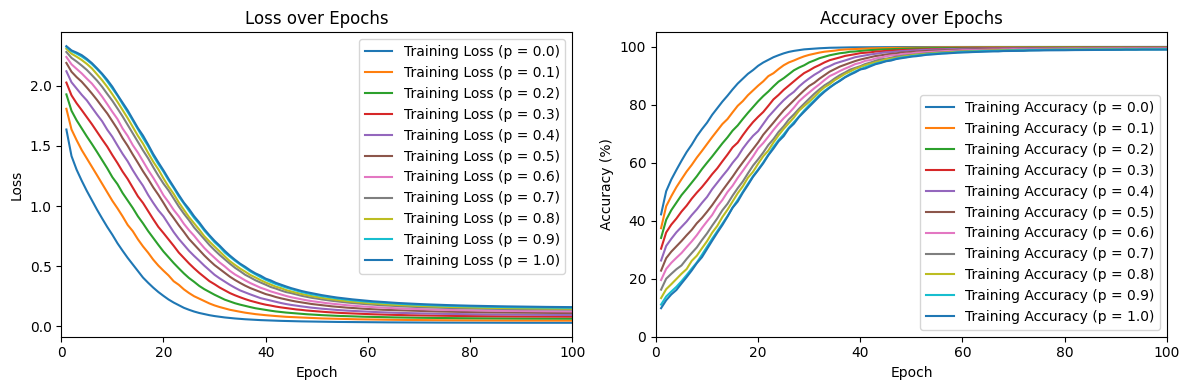

In [27]:
import matplotlib.pyplot as plt


# Plot the training history
plt.figure(figsize=(12, 4))

for result in mlp512_results:
    training_history = result['training_history']
    p = result['random_label_p']
    plot_epochs = list(range(1, len(training_history['train_loss']) + 1))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(plot_epochs, training_history['train_loss'], label=f'Training Loss ({p = })')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(0, 100)
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(plot_epochs, training_history['train_accuracy'], label=f'Training Accuracy ({p = })')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xlim(0, 100)
    plt.ylim(0, 105)
    plt.legend()
    
plt.tight_layout()
plt.show()

In [ ]:
# Train AlexNet

alexnet_results = []
for i in range(11):
    p = i / 10
    print(f'\nRunning experiment for random_label_p = {p}')
    training_history = experiment_random_labels(p, AlexNet, num_epochs=200)
    alexnet_results.append({'random_label_p': p, 'training_history': training_history})

import pickle
import datetime

filename = '2025-12-21-reproduce-zhang-2017-understanding/random-labels-alexnet-' + datetime.datetime.now().isoformat()[:19] + '.pickle'
with open(filename, 'wb') as f:
    pickle.dump(alexnet_results, f)

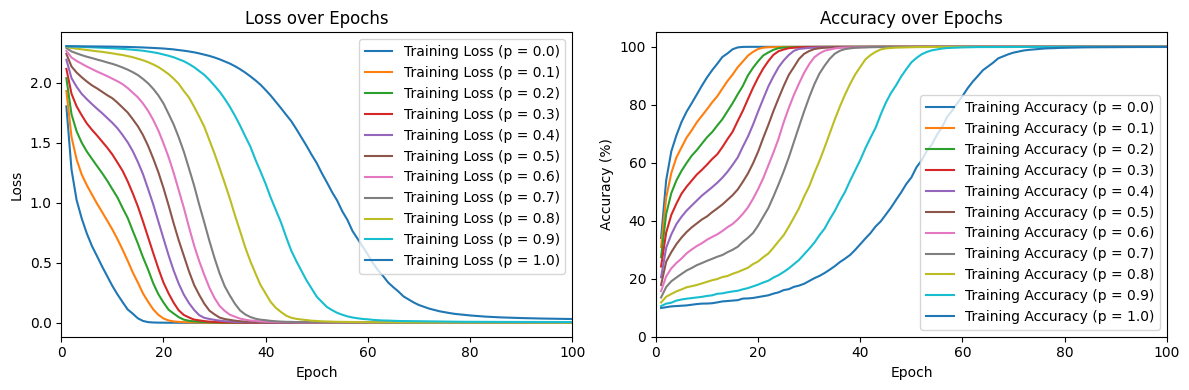

In [60]:
import matplotlib.pyplot as plt


# Plot the training history
plt.figure(figsize=(12, 4))

for result in alexnet_results:
    training_history = result['training_history']
    p = result['random_label_p']
    plot_epochs = list(range(1, len(training_history['train_loss']) + 1))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(plot_epochs, training_history['train_loss'], label=f'Training Loss ({p = })')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(0, 100)
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(plot_epochs, training_history['train_accuracy'], label=f'Training Accuracy ({p = })')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xlim(0, 100)
    plt.ylim(0, 105)
    plt.legend()
    
plt.tight_layout()
plt.show()

## Reproduce plots

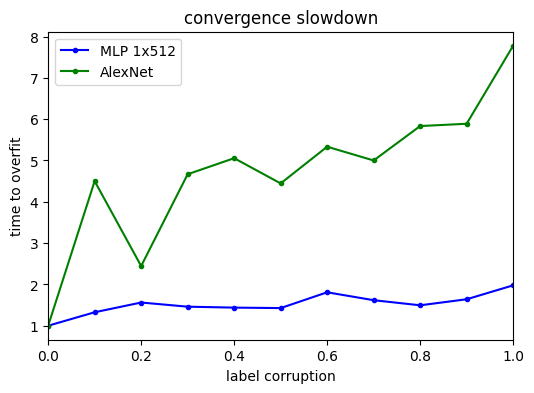

In [61]:
import numpy as np

plot_p = []
mlp512_overfit_epoch = []
for result in mlp512_results:
    plot_p.append(result['random_label_p'])
    mlp512_overfit_epoch.append(
        np.argwhere(
            np.array(result['training_history']['train_accuracy']) >= result['training_history']['train_accuracy'][-1]
        )
        .flatten()[0]
    )
alexnet_overfit_epoch = []
for result in alexnet_results:
    alexnet_overfit_epoch.append(
        np.argwhere(
            np.array(result['training_history']['train_accuracy']) >= result['training_history']['train_accuracy'][-1]
        )
        .flatten()[0]
    )
            
plt.figure(figsize=(6, 4))
plt.plot(plot_p, np.array(mlp512_overfit_epoch) / mlp512_overfit_epoch[0], '.-', color='blue', label='MLP 1x512')
plt.plot(plot_p, np.array(alexnet_overfit_epoch) / alexnet_overfit_epoch[0], '.-', color='green', label='AlexNet')
plt.xlim(0, 1)
plt.legend()
plt.title('convergence slowdown')
plt.xlabel('label corruption')
plt.ylabel('time to overfit')
plt.show()

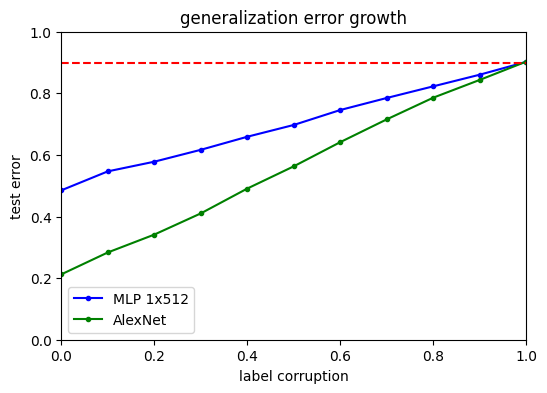

In [62]:
plot_p = []
mlp512_test_error = []
for result in mlp512_results:
    plot_p.append(result['random_label_p'])
    mlp512_test_error.append(1 - result['training_history']['validation_accuracy'][-1]/100)
alexnet_test_error = []
for result in alexnet_results:
    alexnet_test_error.append(1 - result['training_history']['validation_accuracy'][-1]/100)

plt.figure(figsize=(6, 4))
plt.plot(plot_p, mlp512_test_error, '.-', color='blue', label='MLP 1x512')
plt.plot(plot_p, alexnet_test_error, '.-', color='green', label='AlexNet')
plt.ylim(0, plt.ylim()[1])
plt.axhline(0.9, linestyle='--', color='r')
plt.title('generalization error growth')
plt.xlabel('label corruption')
plt.ylabel('test error')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()